In [1]:
import numpy as np
from graphstats.simulations.simulations import *
from graphstats.utils.utils import *
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
from tests.test_ase import kmeans_comparison
from graphstats.embed.ase import AdjacencySpectralEmbed
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import pandas as pd

init_notebook_mode(connected=True)

In [125]:
font_spec = dict(family='Arial', size=18, color='#000000')

def plot_mtx(A, title=""):
    """
    A basic function to plot an adjacency matrix.
    """
    Adf = pd.DataFrame(A).stack().rename_axis(['y', 'x']).reset_index(name="Weight")
    trace = go.Heatmap(x=Adf.x, y=Adf.y, z=Adf.Weight,) #colorscale = 'Viridis'
    data = [trace]
    layout=go.Layout(width=550, height=550,
                     title=title,
                     xaxis=dict(title="Node Out"),
                     yaxis=dict(title="Node In", autorange="reversed",
                               ), font=font_spec)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

def plot_scatter(X, error, title=""):
    #trace = {'x':X[:,0], 'y':X[:,1]}
    trace1 = go.Scatter(x=X[error==False,0], y=X[error==False,1], mode='markers', name='correct')
    trace0 = go.Scatter(x=X[error,0], y=X[error,1], mode='markers', name='incorrect')
    layout=go.Layout(width=550, height=550,
                     title=title,
                     xaxis=dict(title="Dim 1"),
                     yaxis=dict(title="Dim 2", autorange="reversed",),
                    font=font_spec, showlegend=True)
    data = [trace0, trace1]
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)
    


def kmeans_comparison(data, labels, n_clusters, return_predictions=True):
    """
    Function for comparing the ARIs of kmeans clustering for arbitrary number of data/labels

    Parameters
    ----------
        data: list-like 
            each element in the list is a dataset to perform k-means on 
        labels: list-like
            each element in the list is a set of lables with the same number of points as 
            the corresponding data
        n_clusters: int
            the number of clusters to use for k-means 
    
    Returns
    -------
        aris: list, length the same as data/labels
            the i-th element in the list is an ARI (Adjusted Rand Index) corresponding to the result 
            of k-means clustering on the i-th data/labels

    """
    
    if len(data) != len(labels): 
        raise ValueError('Must have same number of labels and data')

    aris = []
    if return_predictions: predictions = []
        
    for i in range(0, len(data)):
        kmeans_prediction = KMeans(n_clusters=n_clusters).fit_predict(data[i])
        aris.append(adjusted_rand_score(labels[i], kmeans_prediction))
        if return_predictions: predictions.append(kmeans_prediction)
    
    if return_predictions:
        return (aris, predictions)
    else:
        return aris

Demonstrate that as probability of connections within a community increases, discriminability (at least by k-means) becomes easier

In [2]:
num_sims = 50
verts = 200
communities = 2 

verts_per_community = [100, 100]

labels_sbm = np.zeros((verts), dtype=np.int8)
labels_er = np.zeros((verts), dtype=np.int8)
labels_sbm[100:] = 1
labels_er[100:] = 1

for insularity in np.linspace(0.5, 0.6, 4):
    P = np.array([[insularity, 1-insularity], [1-insularity, insularity]])
    sbm = weighted_sbm(verts_per_community, P)
    
    plot_mtx(sbm, 'Insularity = {:.3f}'.format(insularity))
    
    embed_sbm = AdjacencySpectralEmbed(k=2)
    embed_sbm.fit(sbm)
    X_sbm = embed_sbm.lpm.X
    kmeans_labels = KMeans(n_clusters=2).fit_predict(X_sbm)
    error = labels_sbm - kmeans_labels
    error = error != 0
    if np.sum(error) / verts > 0.5:
        error = error == 0
    error_rate = np.sum(error)/verts
    
    plot_scatter(X_sbm, error,'Error = {}'.format(error_rate))
    
er = er_np(verts, 0.5)
plot_mtx(er, 'ER')

embed_er = AdjacencySpectralEmbed(k=2)

embed_er.fit(er)

X_er = embed_er.lpm.X

aris, predictions = kmeans_comparison((X_sbm, X_er), (labels_sbm, labels_er), communities)


print(aris)

NameError: name 'plot_mtx' is not defined

C:\Users\Owner\JHU\gs\data\outputs_dmri\dwi\roi-connectomes\aal_res-1x1x1\sub-NDARCD401HGZ_acq-64dir_dwi_aal_res-1x1x1_measure-spatial-ds.edgelist


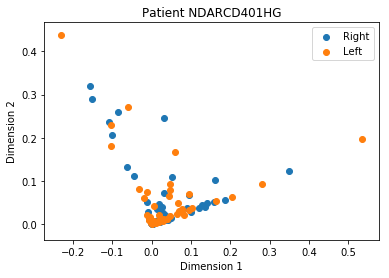

C:\Users\Owner\JHU\gs\data\outputs_dmri\dwi\roi-connectomes\aal_res-1x1x1\sub-NDARCJ007GF8_acq-64dir_dwi_aal_res-1x1x1_measure-spatial-ds.edgelist


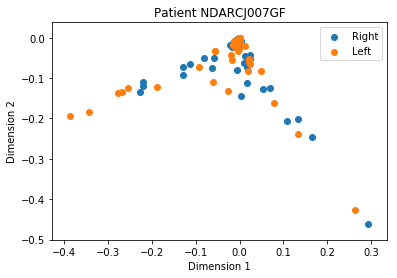

C:\Users\Owner\JHU\gs\data\outputs_dmri\dwi\roi-connectomes\aal_res-1x1x1\sub-NDARCL080RHP_acq-64dir_dwi_aal_res-1x1x1_measure-spatial-ds.edgelist


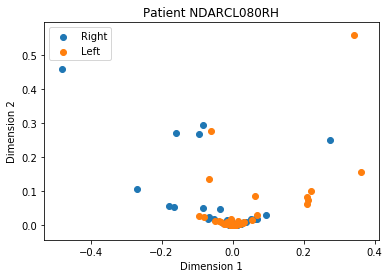

C:\Users\Owner\JHU\gs\data\outputs_dmri\dwi\roi-connectomes\aal_res-1x1x1\sub-NDARCP360AFD_acq-64dir_dwi_aal_res-1x1x1_measure-spatial-ds.edgelist


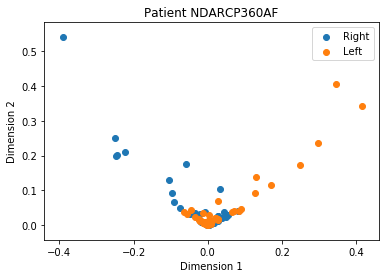

C:\Users\Owner\JHU\gs\data\outputs_dmri\dwi\roi-connectomes\aal_res-1x1x1\sub-NDARCT933HF2_acq-64dir_dwi_aal_res-1x1x1_measure-spatial-ds.edgelist


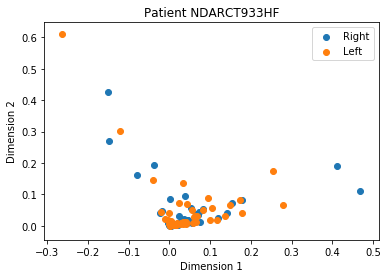

In [8]:
import networkx as nx
import pandas as pd 
#import pygraphstats as pygr
import abc
from sklearn.decomposition import TruncatedSVD
import numpy as np
import os
import matplotlib.pyplot as plt

path = 'C:\\Users\\Owner\\JHU\\gs\\data\\outputs_dmri\\dwi\\roi-connectomes\\aal_res-1x1x1'

def plot_ase_embedding(file):
    G = nx.read_weighted_edgelist('{}\\{}'.format(path,file))
    x_hat, eigval = adj_spectral_embedding(G,)
    plt.scatter(x_hat[:,0], x_hat[:,1])

def make_graph_from_doubles(filename):
    with open(filename) as file: 
        line = file.read()
        vals = line.split()

    m = list(map(float, vals))
    vals = np.array(m)
    vals = np.reshape(vals, (int(vals.shape[0]/3),3))

    G = nx.Graph()
    for i in range(vals.shape[0]):
        G.add_edge(int(vals[i, 0]), int(vals[i,1]), weight=int(vals[i, 2]))
    return G


edgelists = os.listdir(path)
for graph in edgelists[25:30]:
    filename = '{}\\{}'.format(path,graph)
    print(filename) 
    G = make_graph_from_doubles(filename)
    embed_sbm = AdjacencySpectralEmbed(k=2)
    embed_sbm.fit(G)
    x_hat = embed_sbm.lpm.X
    nodes = list(G.nodes())
    colors = []
    right = []
    left = []
    for n in nodes:
        if n < 109:
            colors.append([n%2, 0, (1 - n%2)])
            left.append(bool(n%2))
            right.append(bool(1-n%2))
        else:
            colors.append([0, 0,0,])
            right.append(False)
            left.append(False)
    plt.scatter(x_hat[right,0], x_hat[right,1], label='Right')
    plt.scatter(x_hat[left,0], x_hat[left,1], label = 'Left')
    plt.legend()
    plt.title('Patient {}'.format(graph[4:15],))
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    
    plt.savefig('C:\\Users\\Owner\\JHU\\gs\\exploratory\\output\\ase_hemisphere\\new{}.png'.format(graph[4:15]))
    plt.show()